In [1]:

### Import Packages ###
import pandas as pd
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt


### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###
industriales = pd.read_csv('Industriales.csv', header=0, squeeze=True)


ts= industriales[['Dia', 'ConsumoDia']]
ts=ts.set_index('Dia')

print (pdq)
print (pdqs)
ts.head(10)


[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
[(0, 0, 0, 365), (0, 0, 1, 365), (0, 0, 2, 365), (0, 1, 0, 365), (0, 1, 1, 365), (0, 1, 2, 365), (0, 2, 0, 365), (0, 2, 1, 365), (0, 2, 2, 365), (1, 0, 0, 365), (1, 0, 1, 365), (1, 0, 2, 365), (1, 1, 0, 365), (1, 1, 1, 365), (1, 1, 2, 365), (1, 2, 0, 365), (1, 2, 1, 365), (1, 2, 2, 365), (2, 0, 0, 365), (2, 0, 1, 365), (2, 0, 2, 365), (2, 1, 0, 365), (2, 1, 1, 365), (2, 1, 2, 365), (2, 2, 0, 365), (2, 2, 1, 365), (2, 2, 2, 365)]


,ConsumoDia
Dia,
2014-01-01,747.979167
2014-02-01,890.083333
2014-03-01,997.500000
2014-04-01,991.191489
2014-05-01,979.234043
2014-06-01,968.313830
2014-07-01,1075.250000
2014-08-01,1328.447674
2014-09-01,1505.209302


In [2]:

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='MS'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs, 
                                                enforce_invertibility=False,#Hemos quitado enforce_stationarity=False,
                                                freq=freq)
               
                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                print('error')
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data

#------------------------------------------------------------------------------------------------------------------------
#resultado = sarimax_gridsearch(ts, pdq, pdqs, freq='D')

#print(resultado)
#------------------------------------------------------------------------------------------------------------------------


C:\Users\irene\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                          ConsumoDia   No. Observations:                   78
Model:             SARIMAX(0, 2, 2)x(1, 0, [], 12)   Log Likelihood                -534.505
Date:                             Mon, 26 Apr 2021   AIC                           1077.009
Time:                                     12:18:57   BIC                           1086.332
Sample:                                 01-01-2014   HQIC                          1080.735
                                      - 06-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5319      0.182     -2.918      0.004      -0.889      -0.175
ma.L2         -0.4681      

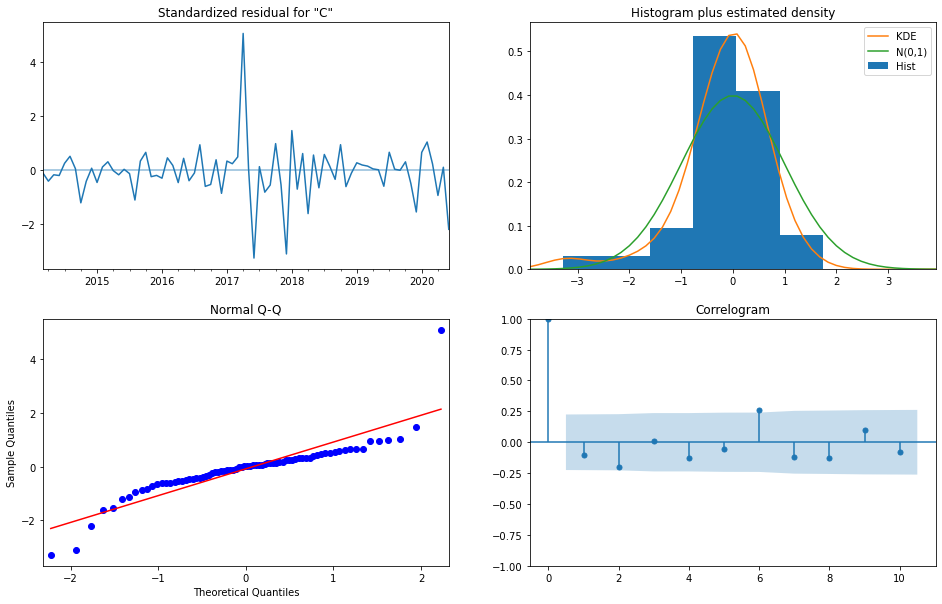

In [3]:

#de lo anterior cogeemos os parametros que esten en el compromiso de bajo BIC pero bajo error cuadratico

# Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts, 
                                    order=(0,2,2), 
                                    seasonal_order=(1,0,0,12), #hemos quitado enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='MS')
                                    
# Fit the model
output = sarimax.fit()
    
# Print output summary
print(output.summary())

# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));



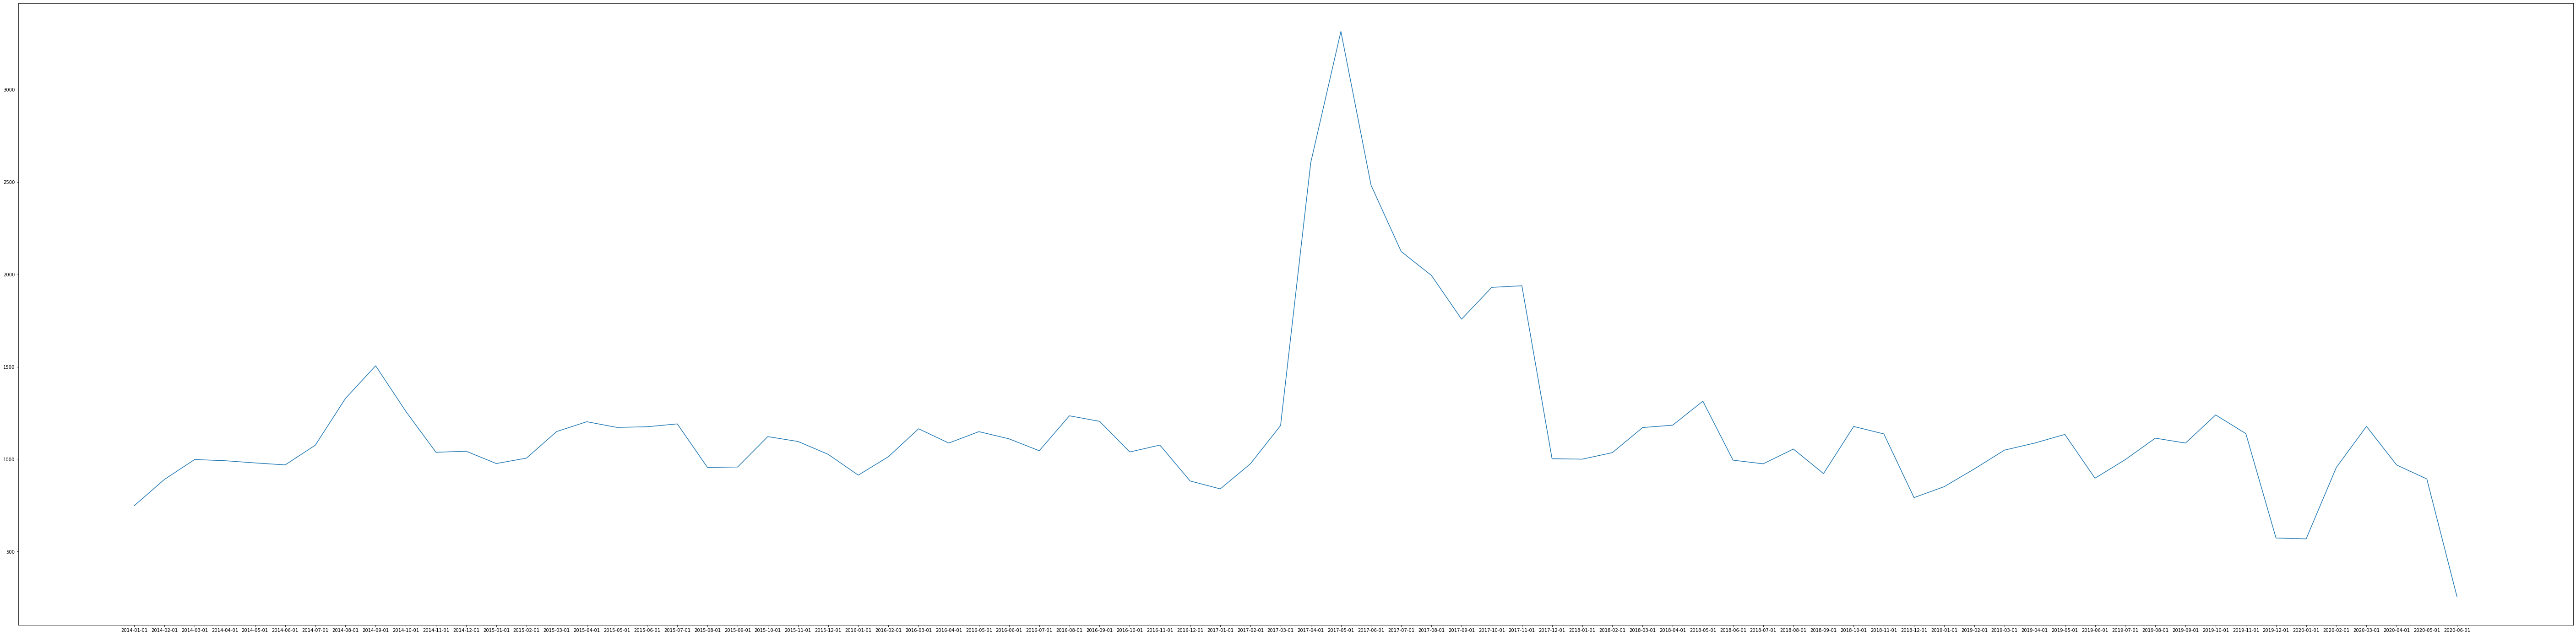

In [4]:
plt.figure(figsize=(100,25))

plt.plot(ts)

AttributeError: 'list' object has no attribute 'get_figure'

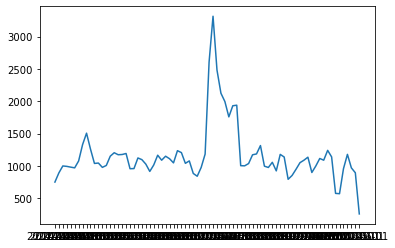

In [8]:
pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts[''.plot(ts,label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [14]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-06-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

NameError: name 'y' is not defined

In [ ]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

In [ ]:
pred_ci.head(24)


In [ ]:
forecast = pred_uc.predicted_mean
forecast.head(12)